In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import scipy.stats as st

In [2]:
exons = pd.read_csv('../../EVENT_INFO-hg38.tab.gz', sep='\t')[['EVENT', 'COMPLEX', 'CO_C1', 'CO_A', 'CO_C2', 'LE_n']].dropna()

polyA_psi = pd.read_csv('../code/QTLs/QTLTools/polyA.Splicing/OnlyFirstReps.PSI.bed.gz', sep='\t')
chRNA_psi = pd.read_csv('../code/QTLs/QTLTools/chRNA.Splicing/OnlyFirstReps.PSI.bed.gz', sep='\t')

exons = exons.loc[~exons.COMPLEX.isin(['MIC_S', 'IR', 'Alt3', 'Alt5', 'MIC-M'])]

In [3]:

exon = exons.EVENT
LE = exons.LE_n
c1 = exons.CO_C1.str.split('-', expand=True)
chrom = c1[0].str.split(':', expand=True)[0]
donor_c1 = c1[1].astype(int)

ca = exons.CO_A.str.split('-', expand=True)
receptor_c1 = ca[0].str.split(':', expand=True)[1].astype(int) - 1
donor_c2 = ca[1].astype(int)

c2 = exons.CO_C2.str.split('-', expand=True)
receptor_c2 = c2[0].str.split(':', expand=True)[1].astype(int) - 1

exon = exons.EVENT
LE = exons.LE_n
c1 = exons.CO_C1.str.split('-', expand=True)
chrom = c1[0].str.split(':', expand=True)[0]
donor_c1 = c1[1].astype(int)

ca = exons.CO_A.str.split('-', expand=True)
receptor_c1 = ca[0].str.split(':', expand=True)[1].astype(int) - 1
donor_c2 = ca[1].astype(int)

c2 = exons.CO_C2.str.split('-', expand=True)
receptor_c2 = c2[0].str.split(':', expand=True)[1].astype(int) - 1



In [4]:
impact = pd.read_csv('../../PROT_IMPACT-hg38-v3.tab.gz', sep='\t')
impact.index = impact.EventID
# cons = pd.read_csv('../../EVENT_CONSERVATION.tab.gz', sep='\t')

df = pd.DataFrame()
df['event'] = list(exon)
df['chrom'] = list(chrom)
df['donor_c1'] = list(donor_c1)
df['receptor_c1'] = list(receptor_c1)
df['donor_c2'] = list(donor_c2)
df['receptor_c2'] = list(receptor_c2)
df['LE_n'] = list(LE)
df = df.loc[[x[:5]=='HsaEX' for x in df.event]]
df = df.loc[df.event.isin(impact.loc[~impact.ONTO.isin(['NonCoding', "5' UTR", "3' UTR"])].index)]

polyA_psi.end -= 1
chRNA_psi.end -= 1

samples = polyA_psi.columns[6:]

c1 = df.merge(polyA_psi, left_on=['chrom', 'donor_c1', 'receptor_c1'], right_on=['#Chr', 'start', 'end'])
c2 = df.merge(polyA_psi, left_on=['chrom', 'donor_c2', 'receptor_c2'], right_on=['#Chr', 'start', 'end'])
ca = df.merge(polyA_psi, left_on=['chrom', 'donor_c1', 'receptor_c2'], right_on=['#Chr', 'start', 'end'])

c1 = c1.set_index('event').dropna()
c2 = c2.set_index('event').dropna()
ca = ca.set_index('event').dropna()

shared_idx = c1.index.intersection(c2.index.intersection(ca.index))
shared_idx = shared_idx[(c1.loc[shared_idx, samples] - c2.loc[shared_idx, samples]).abs().mean(axis=1) <= 0.333]

psi_c1 = c1.loc[shared_idx, samples]
psi_c2 = c2.loc[shared_idx, samples]
psi_ca = ca.loc[shared_idx, samples]

psi = (psi_c1 + psi_c2)/(psi_c1 + psi_c2 + (2*psi_ca))

c1 = df.merge(chRNA_psi, left_on=['chrom', 'donor_c1', 'receptor_c1'], right_on=['#Chr', 'start', 'end'])
c2 = df.merge(chRNA_psi, left_on=['chrom', 'donor_c2', 'receptor_c2'], right_on=['#Chr', 'start', 'end'])
ca = df.merge(chRNA_psi, left_on=['chrom', 'donor_c1', 'receptor_c2'], right_on=['#Chr', 'start', 'end'])

c1 = c1.set_index('event').dropna()
c2 = c2.set_index('event').dropna()
ca = ca.set_index('event').dropna()

samples = chRNA_psi.columns[6:]

shared_idx = c1.index.intersection(c2.index.intersection(ca.index))
shared_idx = shared_idx[(c1.loc[shared_idx, samples] - c2.loc[shared_idx, samples]).abs().mean(axis=1) <= 0.333]

psi_c1 = c1.loc[shared_idx, samples]
psi_c2 = c2.loc[shared_idx, samples]
psi_ca = ca.loc[shared_idx, samples]

psi_chRNA = (psi_c1 + psi_c2)/(psi_c1 + psi_c2 + (2*psi_ca))




In [5]:

ORF_distupt = ['ORF disruption upon sequence inclusion', 'ORF disruption upon sequence inclusion (1st CDS intron)',
               'ORF disruption when splice site is used (sequence inclusion)']

NMD_impact = ['ORF disruption upon sequence inclusion (Alt. Stop)']

NMD_excl = ['ORF disruption upon sequence exclusion',
 'ORF disruption upon sequence exclusion (Ref, Alt. ATG (<=10 exons))']

sorted(impact.loc[~impact.ONTO.isin(['NonCoding', "5' UTR", "3' UTR"])].ONTO.fillna('none').unique())
uncertain = ['In the CDS, with uncertain impact']
protein_coding = ['Alternative protein isoforms',
 'Alternative protein isoforms (No Ref)',
 'Alternative protein isoforms (No Ref, Alt. ATG)',
 'Alternative protein isoforms (No Ref, Alt. Stop)',
 'Alternative protein isoforms (Ref)',
 'Alternative protein isoforms (Ref, Alt. ATG (>10 exons))',
 'Alternative protein isoforms (Ref, Alt. Stop)',]

impact_ = []
for idx, row in impact.iterrows():
    i = row.ONTO
    if i in NMD_impact:
        impact_.append('poison exon')
    elif i in NMD_excl:
        impact_.append('NMD upon exclusion')
    elif i in protein_coding:
        impact_.append('alt. protein coding')
    elif i in ORF_distupt:
        impact_.append('poison exon')
    elif i in uncertain:
        impact_.append('uncertain')
    else:
        impact_.append('uncertain')
        
impact['impact'] = impact_

df = df.set_index('event')
psi_chRNA = psi_chRNA[[x for x in psi_chRNA.columns if x != 'NA18855']]

100%|██████████| 86/86 [00:04<00:00, 18.92it/s]


Text(0, 0.5, 'Percent symmetric')

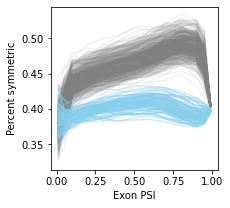

In [8]:
from tqdm import tqdm
fig, ax = plt.subplots(figsize=(3, 3))

# shr = psi.index.intersection


for s in tqdm(psi.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi.loc[(psi[s] <= b1) & (psi[s] > b0)].index].LE_n%3)==0).mean())
        
    if vals[0]>0.9:
        continue
    ax.plot(np.array(bins[:-1]), vals, c='gray', alpha=0.1)
#     ax.plot(np.log10(np.array(bins[:-1])), vals, c='gray', alpha=0.1)
        
for s in tqdm(psi_chRNA.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[0]
        vals.append(((df.loc[psi_chRNA.loc[(psi_chRNA[s] <= b1) & (psi_chRNA[s] > b0)].index].LE_n%3)==0).mean())
        
#     if vals[0]>0.9:
#         continue
    ax.plot(np.array(bins[:-1]), vals, c='skyblue', alpha=0.4)
#     ax.plot(np.log10(np.array(bins[:-1])), vals, c='skyblue', alpha=0.4)
        
# ax.set_xticks(np.log10(np.array(bins[:-1])), ['0.01', '0.05', '0.1', '0.2', '0.3', '0.4', '0.5'])

ax.set_xlabel('Exon PSI')
ax.set_ylabel('Percent symmetric')

In [6]:
poison_exon_index = impact.loc[impact.impact == 'poison exon'].index
poison_skipping_index = impact.loc[impact.impact == 'NMD upon exclusion'].index
alt_exon_index = impact.loc[impact.impact == 'alt. protein coding'].index

In [7]:
polyA_poison_exons = psi.loc[psi.index.intersection(poison_exon_index)]
polyA_poison_skipping = 1 - psi.loc[psi.index.intersection(poison_skipping_index)]
polyA_alt_prot = psi.loc[psi.index.intersection(alt_exon_index)]
polyA_NMD_psi = pd.concat([polyA_poison_exons, polyA_poison_skipping], axis=0)
polyA_NMD_event_psi = pd.concat([polyA_poison_exons, polyA_poison_skipping, polyA_alt_prot], axis=0)

chRNA_poison_exons = psi_chRNA.loc[psi_chRNA.index.intersection(poison_exon_index)]
chRNA_poison_skipping = 1 - psi_chRNA.loc[psi_chRNA.index.intersection(poison_skipping_index)]
chRNA_alt_prot = psi_chRNA.loc[psi_chRNA.index.intersection(alt_exon_index)]

chRNA_NMD_psi = pd.concat([chRNA_poison_exons, chRNA_poison_skipping], axis=0)
chRNA_NMD_event_psi = pd.concat([chRNA_poison_exons, chRNA_poison_skipping, chRNA_alt_prot], axis=0)

100%|██████████| 86/86 [00:00<00:00, 111.68it/s]


TypeError: set_ticks() takes 2 positional arguments but 3 were given

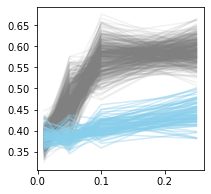

In [8]:
from tqdm import tqdm
fig, ax = plt.subplots(figsize=(3, 3))

# shr = psi.index.intersection


for s in tqdm(psi.columns):
    bins = [1e-2, 0.05, 0.1, 0.25, 0.75]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[i-1]
        
        vals.append(((df.loc[psi.loc[(psi[s] <= b1) & (psi[s] > b0)].index].LE_n%3)==0).mean())
        
    if vals[0]>0.9:
        continue
    ax.plot(np.array(bins[:-1]), vals, c='gray', alpha=0.1)
#     ax.plot(np.log10(np.array(bins[:-1])), vals, c='gray', alpha=0.1)
        
for s in tqdm(psi_chRNA.columns):
    bins = [1e-2, 0.05, 0.1, 0.25, 0.75]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[i-1]
        vals.append(((df.loc[psi_chRNA.loc[(psi_chRNA[s] <= b1) & (psi_chRNA[s] > b0)].index].LE_n%3)==0).mean())
        
#     if vals[0]>0.9:
#         continue
    ax.plot(np.array(bins[:-1]), vals, c='skyblue', alpha=0.4)
#     ax.plot(np.log10(np.array(bins[:-1])), vals, c='skyblue', alpha=0.4)
        
ax.set_xticks(np.array(bins[:-1]), ['0.01-0.05', '0.05-0.1', '0.1-0.25', '0.25-0.75'])

ax.set_xlabel('Exon PSI')
ax.set_ylabel('Percent symmetric')

In [9]:
def get_gm_list(gm):
    ctrl1_list = []
    ctrl1_list.append(((gm.loc[(gm.PSI >= 0.01) & (gm.PSI < 0.05)].LE_n % 3) == 0).mean())
    ctrl1_list.append(((gm.loc[(gm.PSI >= 0.05) & (gm.PSI < 0.1)].LE_n % 3) == 0).mean())
    ctrl1_list.append(((gm.loc[(gm.PSI >= 0.1) & (gm.PSI < 0.25)].LE_n % 3) == 0).mean())
    ctrl1_list.append(((gm.loc[(gm.PSI >= 0.25) & (gm.PSI < 0.75)].LE_n % 3) == 0).mean())
    
    return ctrl1_list

ctrl1 = pd.read_csv('../code/LongReads/Exons/CTRL1_shRNA.SAMEA8691110.cassette_exons.tab.gz', sep='\t', index_col=0)
ctrl1_list = get_gm_list(ctrl1)

ctrl2 = pd.read_csv('../code/LongReads/Exons/CTRL2_shRNA.SAMEA8691111.cassette_exons.tab.gz', sep='\t', index_col=0)
ctrl2_list = get_gm_list(ctrl2)

NMD_KD = pd.read_csv('../code/LongReads/Exons/SMG6_SMG7_shRNA.SAMEA8691113.cassette_exons.tab.gz', sep='\t', index_col=0)
NMD_KD_list = get_gm_list(NMD_KD)

chRNA3 = pd.read_csv('../code/LongReads/Exons/K562_4sUchr_ONT_3.SAMN10505967.cassette_exons.tab.gz', sep='\t', index_col=0)
chRNA3_list = get_gm_list(chRNA3)

chRNA4 = pd.read_csv('../code/LongReads/Exons/K562_4sUchr_ONT_4.SAMN12726878.cassette_exons.tab.gz', sep='\t', index_col=0)
chRNA4_list = get_gm_list(chRNA4)

chRNA5a = pd.read_csv('../code/LongReads/Exons/K562_4sUchr_ONT_5a.SAMN12726877.cassette_exons.tab.gz', sep='\t', index_col=0)
chRNA5a_list = get_gm_list(chRNA5a)

chRNA5b = pd.read_csv('../code/LongReads/Exons/K562_4sUchr_ONT_5b.SAMN12726876.cassette_exons.tab.gz', sep='\t', index_col=0)
chRNA5b_list = get_gm_list(chRNA5b)

upf1 = pd.read_csv('../code/LongReads/Exons/UPF1_shRNA.SAMEA8691115.cassette_exons.tab.gz', sep='\t', index_col=0)
upf1_list = get_gm_list(upf1)

In [10]:
chRNA3.columns = ['skipped_3', 'included_3', 'PSI_3', 'LE_n_3']
chRNA4.columns = ['skipped_4', 'included_4', 'PSI_4', 'LE_n_4']
chRNA5a.columns = ['skipped_5a', 'included_5a', 'PSI_5a', 'LE_n_5a']
chRNA5b.columns = ['skipped_5b', 'included_5b', 'PSI_5b', 'LE_n_5b']

chRNA_merged = pd.merge(chRNA3, chRNA4, how='outer', left_on='exon', right_on='exon').fillna(0)
chRNA_merged = pd.merge(chRNA_merged, chRNA5a, how='outer', left_on='exon', right_on='exon').fillna(0)
chRNA_merged = pd.merge(chRNA_merged, chRNA5b, how='outer', left_on='exon', right_on='exon').fillna(0)

chRNA_merged['skipped'] = chRNA_merged.skipped_3 + chRNA_merged.skipped_4 + chRNA_merged.skipped_5a + chRNA_merged.skipped_5b
chRNA_merged['included'] = chRNA_merged.included_3 + chRNA_merged.included_4 + chRNA_merged.included_5a + chRNA_merged.included_5b

chRNA_merged['LE_n'] = chRNA_merged[['LE_n_3', 'LE_n_4', 'LE_n_5a', 'LE_n_5b']].max(axis=1)

chRNA_merged['PSI'] = chRNA_merged.included/(chRNA_merged.included + chRNA_merged.skipped)

100%|██████████| 86/86 [00:00<00:00, 112.91it/s]


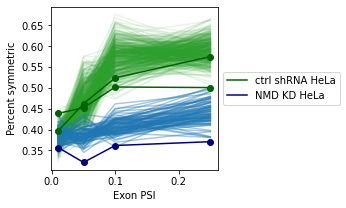

In [13]:
from tqdm import tqdm
fig, ax = plt.subplots(figsize=(3, 3))

# shr = psi.index.intersection


for s in tqdm(psi.columns):
    bins = [1e-2, 0.05, 0.1, 0.25, 0.75]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[i-1]
        
        vals.append(((df.loc[psi.loc[(psi[s] <= b1) & (psi[s] > b0)].index].LE_n%3)==0).mean())
        
    if vals[0]>0.9:
        continue
    ax.plot(np.array(bins[:-1]), vals, c='tab:green', alpha=0.1)
#     ax.plot(np.log10(np.array(bins[:-1])), vals, c='gray', alpha=0.1)
        
for s in tqdm(psi_chRNA.columns):
    bins = [1e-2, 0.05, 0.1, 0.25, 0.75]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[i-1]
        vals.append(((df.loc[psi_chRNA.loc[(psi_chRNA[s] <= b1) & (psi_chRNA[s] > b0)].index].LE_n%3)==0).mean())
        
#     if vals[0]>0.9:
#         continue
    ax.plot(np.array(bins[:-1]), vals, c='tab:blue', alpha=0.4)
#     ax.plot(np.log10(np.array(bins[:-1])), vals, c='skyblue', alpha=0.4)
        
# ax.set_xticks(np.array(bins[:-1]), ['0.01-0.05', '0.05-0.1', '0.1-0.25', '0.25-0.75'])

ax.set_xlabel('Exon PSI')
ax.set_ylabel('Percent symmetric')

ax.plot([0.01, 0.05, 0.1, 0.25], ctrl1_list, c='darkgreen')
ax.scatter([0.01, 0.05, 0.1, 0.25], ctrl1_list, c='darkgreen', zorder=10)
ax.plot([0.01, 0.05, 0.1, 0.25], ctrl2_list, c='darkgreen', label='ctrl shRNA HeLa')
ax.scatter([0.01, 0.05, 0.1, 0.25], ctrl2_list, c='darkgreen', zorder=10)
ax.plot([0.01, 0.05, 0.1, 0.25], NMD_KD_list, c='navy', label='NMD KD HeLa')
ax.scatter([0.01, 0.05, 0.1, 0.25], NMD_KD_list, c='navy', zorder=10)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [218]:
ctrl1_list

[0.3968871595330739,
 0.4620253164556962,
 0.5240174672489083,
 0.5746478873239437]

In [14]:
from tqdm import tqdm

vals_polyA = []

for s in tqdm(psi.columns):
    bins = [1e-2, 0.05, 0.1, 0.25, 0.75]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[i-1]
        
        vals.append(((df.loc[psi.loc[(psi[s] <= b1) & (psi[s] > b0)].index].LE_n%3)==0).mean())
        
    if vals[0]>0.9:
        continue
    vals_polyA.append(vals)

vals_chRNA = []
    
for s in tqdm(psi_chRNA.columns):
    bins = [1e-2, 0.05, 0.1, 0.25, 0.75]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[i-1]
        vals.append(((df.loc[psi_chRNA.loc[(psi_chRNA[s] <= b1) & (psi_chRNA[s] > b0)].index].LE_n%3)==0).mean())

    vals_chRNA.append(vals)
        


100%|██████████| 86/86 [00:00<00:00, 118.67it/s]


In [15]:
mean_list = [np.mean(np.array(vals_chRNA).T[i]) for i in range(4)]
ci_90 = [np.quantile(np.array(vals_chRNA).T[i], 0.95)  for i in range(4)]
ci_10 = [np.quantile(np.array(vals_chRNA).T[i], 0.05)  for i in range(4)]

mean_list_ = [np.mean(np.array(vals_polyA).T[i]) for i in range(4)]

ci_90_ = [np.quantile(np.array(vals_polyA).T[i], 0.95)  for i in range(4)]
ci_10_ = [np.quantile(np.array(vals_polyA).T[i], 0.05)  for i in range(4)]
# ci_list_ = [1 * np.std(np.array(vals_polyA).T[i])/np.mean(np.array(vals_polyA).T[i])  for i in range(4)]

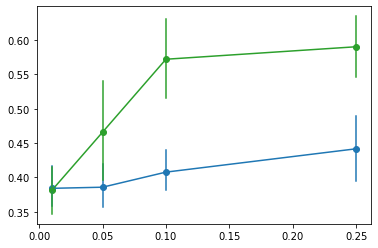

In [16]:
plt.scatter([0.01, 0.05, 0.1, 0.25], mean_list, c='tab:blue', zorder=10)
plt.plot([0.01, 0.05, 0.1, 0.25], mean_list, c='tab:blue', zorder=10)
plt.plot([0.01, 0.01], [ci_10[0], ci_90[0]], c='tab:blue', zorder=10)
plt.plot([0.05, 0.05], [ci_10[1], ci_90[1]], c='tab:blue', zorder=10)
plt.plot([0.1, 0.1], [ci_10[2], ci_90[2]], c='tab:blue', zorder=10)
plt.plot([0.25, 0.25], [ci_10[3], ci_90[3]], c='tab:blue', zorder=10)


plt.scatter([0.01, 0.05, 0.1, 0.25], mean_list_, c='tab:green', zorder=10)
plt.plot([0.01, 0.05, 0.1, 0.25], mean_list_, c='tab:green', zorder=10)
plt.plot([0.01, 0.01], [ci_10_[0], ci_90_[0]], c='tab:green', zorder=10)
plt.plot([0.05, 0.05], [ci_10_[1], ci_90_[1]], c='tab:green', zorder=10)
plt.plot([0.1, 0.1], [ci_10_[2], ci_90_[2]], c='tab:green', zorder=10)
plt.plot([0.25, 0.25], [ci_10_[3], ci_90_[3]], c='tab:green', zorder=10)


In [24]:
long_table = pd.read_csv(
    '../code/SplicingAnalysis/CombinedJuncTables/NMD_KD.tsv.gz', sep='\t'
)


In [25]:
df = pd.DataFrame()
df['event'] = list(exon)
df['chrom'] = list(chrom)
df['donor_c1'] = list(donor_c1)
df['receptor_c1'] = list(receptor_c1)
df['donor_c2'] = list(donor_c2)
df['receptor_c2'] = list(receptor_c2)
df['LE_n'] = list(LE)
df = df.loc[[x[:5]=='HsaEX' for x in df.event]]
df = df.loc[df.event.isin(impact.loc[~impact.ONTO.isin(['NonCoding', "5' UTR", "3' UTR"])].index)]
df = df.set_index('event', drop=False)


In [103]:
def get_PSI(long_table, df, dataset):
    c1 = df.merge(long_table.loc[long_table.Dataset==dataset], 
         left_on=['chrom', 'donor_c1', 'receptor_c1'], right_on=['chrom', 'start', 'stop'])

    c1 = pd.pivot_table(c1, values='Count', index='event', columns='IndID', fill_value=0)

    c2 = df.merge(long_table.loc[long_table.Dataset==dataset], 
             left_on=['chrom', 'donor_c2', 'receptor_c2'], right_on=['chrom', 'start', 'stop'])

    c2 = pd.pivot_table(c2, values='Count', index='event', columns='IndID', fill_value=0)


    ca = df.merge(long_table.loc[long_table.Dataset==dataset], 
             left_on=['chrom', 'donor_c1', 'receptor_c2'], right_on=['chrom', 'start', 'stop'])

    ca = pd.pivot_table(ca, values='Count', index='event', columns='IndID', fill_value=0)


    all_index = c1.index.union(c2.index).union(ca.index)

    c1 = c1.reindex(all_index).fillna(0)
    c2 = c2.reindex(all_index).fillna(0)
    ca = ca.reindex(all_index).fillna(0)

    filtered_index = all_index[(c1+c2+ca).sum(axis=1) > 10]

    c1 = c1.loc[filtered_index]
    c2 = c2.loc[filtered_index]
    ca = ca.loc[filtered_index]

    c1_mean = (c1/(c1+c2+ca)).mean(axis=1)
    c2_mean = (c2/(c1+c2+ca)).mean(axis=1)

    filtered_index = filtered_index[np.abs(c1_mean - c2_mean) <= 0.333]

    c1 = c1.loc[filtered_index]
    c2 = c2.loc[filtered_index]
    ca = ca.loc[filtered_index]
    PSI = (c1+c2)/(c1+c2+(2*ca))
    
    PSI.loc[PSI.isna().mean(axis=1) < 0.5]
    
    return PSI


In [76]:
HeLa_scr = get_PSI(long_table, df, 'HeLa.scr')
HeLa_dKD = get_PSI(long_table, df, 'HeLa.dKD')
HeLa_UPF1 = get_PSI(long_table, df, 'HeLa.UPF1.KD')
HeLa_SMG7 = get_PSI(long_table, df, 'HeLa.SMG7.KD')
HeLa_SMG6 = get_PSI(long_table, df, 'HeLa.SMG6.KD')

In [126]:
def get_PSI_symmetry_slice(df, PSI, psi_low, psi_high):
    psi_cols = sorted(PSI.columns)
    pct_symmetric = []
    for col in psi_cols:
        pct_symmetric.append(((df.loc[PSI.loc[(PSI[col] >= psi_low) & (PSI[col] <= psi_high)].index, 'LE_n'] %3)==0).mean())
    return pct_symmetric

def get_PSI_symmetry(df, PSI):
    psi_list = []
    psi_list.append(get_PSI_symmetry_slice(df, PSI, 0.01, 0.05))
    psi_list.append(get_PSI_symmetry_slice(df, PSI, 0.05, 0.1))
    psi_list.append(get_PSI_symmetry_slice(df, PSI, 0.1, 0.25))
    psi_list.append(get_PSI_symmetry_slice(df, PSI, 0.25, 0.75))
    
    psi_list = np.array(psi_list).T
    return psi_list

def plot_PSI_symmetry(df, PSI, col, ax, label='', alpha=1, plot_scatter = True):
    X = get_PSI_symmetry(df, PSI)
    counter = 1
    for x in X:
        
        if plot_scatter:
            ax.plot([0.01, 0.05, 0.1, 0.25], 100*x, c=col, alpha=alpha)
            if counter == 1:
                ax.scatter([0.01, 0.05, 0.1, 0.25], 100*x, c=col, zorder=1, label=label)
            else:
                ax.scatter([0.01, 0.05, 0.1, 0.25], 100*x, c=col, zorder=1)
        else:
            if counter == 1:
                ax.plot([0.01, 0.05, 0.1, 0.25], 100*x, c=col, alpha=alpha, label=label)
            else:
                ax.plot([0.01, 0.05, 0.1, 0.25], 100*x, c=col, alpha=alpha)
        counter += 1

Text(0, 0.5, 'Pct symmetric')

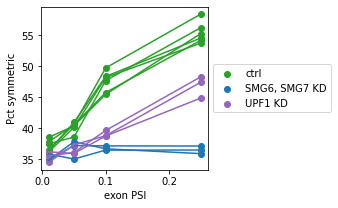

In [80]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_PSI_symmetry(df, HeLa_scr, 'tab:green', ax, 'ctrl')
plot_PSI_symmetry(df, HeLa_dKD, 'tab:blue', ax, 'SMG6, SMG7 KD')
plot_PSI_symmetry(df, HeLa_UPF1, 'tab:purple', ax, 'UPF1 KD')


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('exon PSI')
ax.set_ylabel('Pct symmetric')

[Text(0.01, 0, '0.01 - 0.05'),
 Text(0.05, 0, '0.05 - 0.1'),
 Text(0.1, 0, '0.1 - 0.25'),
 Text(0.25, 0, '0.25 - 0.75')]

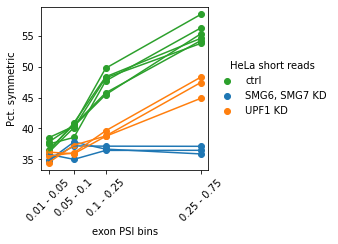

In [95]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_PSI_symmetry(df, HeLa_scr, 'tab:green', ax, 'ctrl')
plot_PSI_symmetry(df, HeLa_dKD, 'tab:blue', ax, 'SMG6, SMG7 KD')
plot_PSI_symmetry(df, HeLa_UPF1, 'tab:orange', ax, 'UPF1 KD')


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='HeLa short reads', frameon=False)
ax.set_xlabel('exon PSI bins')
ax.set_ylabel('Pct. symmetric')
ax.set_xticks([1e-2, 0.05, 0.1, 0.25])
ax.set_xticklabels(['0.01 - 0.05', '0.05 - 0.1', '0.1 - 0.25', '0.25 - 0.75'], rotation=45)

In [96]:
long_table = pd.read_csv(
    '../code/SplicingAnalysis/CombinedJuncTables/YRI.tsv.gz', sep='\t'
)


In [104]:
chRNA = get_PSI(long_table, df, 'chRNA.Expression.Splicing')


In [105]:
polyA = get_PSI(long_table, df, 'Expression.Splicing')


Text(0, 0.5, 'Pct symmetric')

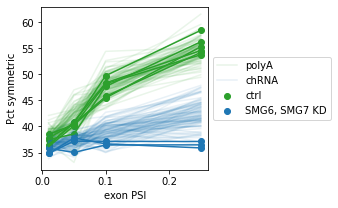

In [127]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_PSI_symmetry(df, polyA, 'tab:green', ax, label='polyA', alpha = 0.1, plot_scatter=False)
plot_PSI_symmetry(df, chRNA, 'tab:blue', ax, label='chRNA', alpha = 0.1, plot_scatter=False)

plot_PSI_symmetry(df, HeLa_scr, 'tab:green', ax, 'ctrl')
plot_PSI_symmetry(df, HeLa_dKD, 'tab:blue', ax, 'SMG6, SMG7 KD')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('exon PSI')
ax.set_ylabel('Pct symmetric')

In [130]:
polyA_symmetric = get_PSI_symmetry(df, polyA)
chRNA_symmetric = get_PSI_symmetry(df, chRNA)
HeLa_scr_symmetric = get_PSI_symmetry(df, HeLa_scr)
HeLa_dKD_symmetric = get_PSI_symmetry(df, HeLa_dKD)

In [210]:
def get_summary_stats(x, interval = (0.05, 0.95)):
    median = np.mean(x)
    quant_10 = np.quantile(x, interval[0])
    quant_90 = np.quantile(x, interval[1])
    return median, quant_10, quant_90

def plot_summary(x, ax, i, c='blue', MarkerStyle='o', label='', interval= (0.05, 0.95)):
    median, quant_10, quant_90 = get_summary_stats(x*100, interval=interval)
    ax.plot([i, i], [quant_10, quant_90], c=c)
    ax.scatter([i], [median], c=c, marker=MarkerStyle, label=label)
    
def plot_mean(x, i_list, ax, c='blue', interval= (0.05, 0.95)):
    
    x_list = []
    for y in x:
        x_list.append(get_summary_stats(y*100, interval=interval)[0])
        
    ax.plot(i_list, x_list, c=c)

def plot_PSI(x, ax, c, label, MarkerStyle='o', interval= (0.05, 0.95)):
    plot_summary(x[0], ax, 0, c=c, label=label, MarkerStyle=MarkerStyle, interval=interval)
    plot_summary(x[1], ax, 3, c=c, MarkerStyle=MarkerStyle, interval=interval)
    plot_summary(x[2], ax, 6, c=c, MarkerStyle=MarkerStyle, interval=interval)
    plot_summary(x[3], ax, 9, c=c, MarkerStyle=MarkerStyle, interval=interval)
    plot_mean(x, [0, 3, 6, 9], ax, c=c, interval=interval)

Text(0, 0.5, 'Pct symmetric')

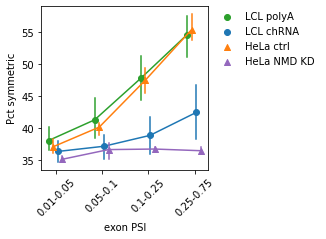

In [202]:
fig, ax = plt.subplots(figsize=(3, 3))

plot_summary(polyA_symmetric.T[0], ax, 0, c='tab:green', label='LCL polyA')
plot_summary(polyA_symmetric.T[1], ax, 3, c='tab:green')
plot_summary(polyA_symmetric.T[2], ax, 6, c='tab:green')
plot_summary(polyA_symmetric.T[3], ax, 9, c='tab:green')
plot_mean(polyA_symmetric.T, [0, 3, 6, 9], ax, c='tab:green')

plot_summary(chRNA_symmetric.T[0], ax, 0.6, c='tab:blue', label='LCL chRNA')
plot_summary(chRNA_symmetric.T[1], ax, 3.6, c='tab:blue')
plot_summary(chRNA_symmetric.T[2], ax, 6.6, c='tab:blue')
plot_summary(chRNA_symmetric.T[3], ax, 9.6, c='tab:blue')
plot_mean(chRNA_symmetric.T, [0.6, 3.6, 6.6, 9.6], ax, c='tab:blue')


plot_summary(HeLa_scr_symmetric.T[0], ax, 0.3, c='tab:orange', MarkerStyle='^', label='HeLa ctrl')
plot_summary(HeLa_scr_symmetric.T[1], ax, 3.3, c='tab:orange', MarkerStyle='^')
plot_summary(HeLa_scr_symmetric.T[2], ax, 6.3, c='tab:orange', MarkerStyle='^')
plot_summary(HeLa_scr_symmetric.T[3], ax, 9.3, c='tab:orange', MarkerStyle='^')
plot_mean(HeLa_scr_symmetric.T, [0.3, 3.3, 6.3, 9.3], ax, c='tab:orange')

plot_summary(HeLa_dKD_symmetric.T[0], ax, 0.9, c='tab:purple', MarkerStyle='^', label='HeLa NMD KD')
plot_summary(HeLa_dKD_symmetric.T[1], ax, 3.9, c='tab:purple', MarkerStyle='^')
plot_summary(HeLa_dKD_symmetric.T[2], ax, 6.9, c='tab:purple', MarkerStyle='^')
plot_summary(HeLa_dKD_symmetric.T[3], ax, 9.9, c='tab:purple', MarkerStyle='^')
plot_mean(HeLa_dKD_symmetric.T, [0.9, 3.9, 6.9, 9.9], ax, c='tab:purple')

ax.set_xticks([0.5, 3.5, 6.5, 9.5])
ax.set_xticklabels(['0.01-0.05', '0.05-0.1', '0.1-0.25', '0.25-0.75'], rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8), frameon=False)
ax.set_xlabel('exon PSI')
ax.set_ylabel('Pct symmetric')

Text(0, 0.5, 'Pct symmetric')

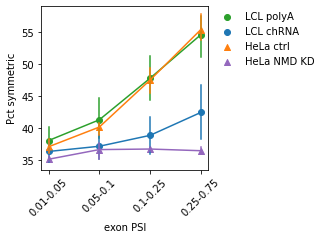

In [204]:
fig, ax = plt.subplots(figsize=(3, 3))

plot_summary(polyA_symmetric.T[0], ax, 0, c='tab:green', label='LCL polyA')
plot_summary(polyA_symmetric.T[1], ax, 3, c='tab:green')
plot_summary(polyA_symmetric.T[2], ax, 6, c='tab:green')
plot_summary(polyA_symmetric.T[3], ax, 9, c='tab:green')
plot_mean(polyA_symmetric.T, [0, 3, 6, 9], ax, c='tab:green')

plot_summary(chRNA_symmetric.T[0], ax, 0, c='tab:blue', label='LCL chRNA')
plot_summary(chRNA_symmetric.T[1], ax, 3, c='tab:blue')
plot_summary(chRNA_symmetric.T[2], ax, 6, c='tab:blue')
plot_summary(chRNA_symmetric.T[3], ax, 9, c='tab:blue')
plot_mean(chRNA_symmetric.T, [0, 3, 6, 9], ax, c='tab:blue')


plot_summary(HeLa_scr_symmetric.T[0], ax, 0, c='tab:orange', MarkerStyle='^', label='HeLa ctrl')
plot_summary(HeLa_scr_symmetric.T[1], ax, 3, c='tab:orange', MarkerStyle='^')
plot_summary(HeLa_scr_symmetric.T[2], ax, 6, c='tab:orange', MarkerStyle='^')
plot_summary(HeLa_scr_symmetric.T[3], ax, 9, c='tab:orange', MarkerStyle='^')
plot_mean(HeLa_scr_symmetric.T, [0, 3, 6, 9], ax, c='tab:orange')

plot_summary(HeLa_dKD_symmetric.T[0], ax, 0, c='tab:purple', MarkerStyle='^', label='HeLa NMD KD')
plot_summary(HeLa_dKD_symmetric.T[1], ax, 3, c='tab:purple', MarkerStyle='^')
plot_summary(HeLa_dKD_symmetric.T[2], ax, 6, c='tab:purple', MarkerStyle='^')
plot_summary(HeLa_dKD_symmetric.T[3], ax, 9, c='tab:purple', MarkerStyle='^')
plot_mean(HeLa_dKD_symmetric.T, [0, 3, 6, 9], ax, c='tab:purple')

ax.set_xticks([0, 3, 6, 9])
ax.set_xticklabels(['0.01-0.05', '0.05-0.1', '0.1-0.25', '0.25-0.75'], rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8), frameon=False)
ax.set_xlabel('exon PSI')
ax.set_ylabel('Pct symmetric')

Text(0, 0.5, 'Pct symmetric')

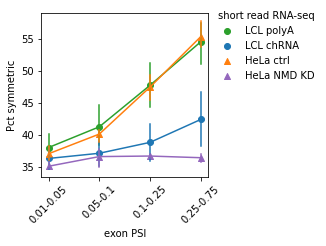

In [223]:
fig, ax = plt.subplots(figsize=(3, 3))

plot_PSI(polyA_symmetric.T, ax, c='tab:green', label='LCL polyA')
plot_PSI(chRNA_symmetric.T, ax, c='tab:blue', label='LCL chRNA')
plot_PSI(HeLa_scr_symmetric.T, ax, c='tab:orange', label='HeLa ctrl', MarkerStyle='^')
plot_PSI(HeLa_dKD_symmetric.T, ax, c='tab:purple', label='HeLa NMD KD', MarkerStyle='^', interval=(0, 1))

ax.set_xticks([0, 3, 6, 9])
ax.set_xticklabels(['0.01-0.05', '0.05-0.1', '0.1-0.25', '0.25-0.75'], rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8), frameon=False, title='short read RNA-seq')
ax.set_xlabel('exon PSI')
ax.set_ylabel('Pct symmetric')



[Text(0, 0, '0.01-0.05'),
 Text(3, 0, '0.05-0.1'),
 Text(6, 0, '0.1-0.25'),
 Text(9, 0, '0.25-0.75')]

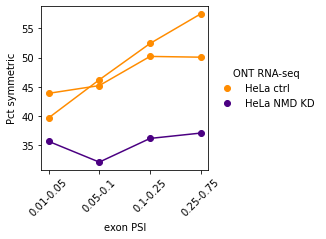

In [248]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.plot([0, 3, 6, 9], np.array(ctrl1_list)*100, c='darkorange')
ax.scatter([0, 3, 6, 9], np.array(ctrl1_list)*100, c='darkorange', zorder=10, label='HeLa ctrl')
ax.plot([0, 3, 6, 9], np.array(ctrl2_list)*100, c='darkorange')
ax.scatter([0, 3, 6, 9], np.array(ctrl2_list)*100, c='darkorange', zorder=10)
ax.plot([0, 3, 6, 9], np.array(NMD_KD_list)*100, c='indigo')
ax.scatter([0, 3, 6, 9], np.array(NMD_KD_list)*100, c='indigo', zorder=10, label='HeLa NMD KD')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='ONT RNA-seq', frameon=False)

ax.set_xlabel('exon PSI')
ax.set_ylabel('Pct symmetric')
ax.set_xticks([0, 3, 6, 9])
ax.set_xticklabels(['0.01-0.05', '0.05-0.1', '0.1-0.25', '0.25-0.75'], rotation=45)

In [140]:
np.quantile(polyA_symmetric.T[0], 0.)

0.4022152155149636

In [241]:
chRNA5b_list

[nan, nan, 0.25, 0.3625]

In [71]:

data = np.array(vals_chRNA).T[0]

st.norm.interval(alpha=0.95, loc=np.mean(data), scale=st.sem(data))

/tmp/ipykernel_2137763/4221168577.py:3: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  st.norm.interval(alpha=0.95, loc=np.mean(data), scale=st.sem(data))


(0.38040792910355237, 0.3880634068899207)

In [65]:
import numpy as np
from scipy import stats

# Replace this with your actual data array
X = data

# Calculate the sample mean and standard error
sample_mean = np.mean(X)
standard_error = stats.sem(X)

# Calculate the degrees of freedom
degrees_of_freedom = len(X) - 1

# Calculate the 95% confidence interval
confidence_interval = stats.t.interval(0.95, degrees_of_freedom, loc=sample_mean, scale=standard_error)

print("95% Confidence Interval:", confidence_interval)


95% Confidence Interval: (0.38035265256435463, 0.3881186834291184)


In [43]:
ci

0.0918463857213555

In [15]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.set_xticks(np.array(bins[:-1]), ['0.01-0.05', '0.05-0.1', '0.1-0.25', '0.25-0.75'])

ax.set_xlabel('Exon PSI')
ax.set_ylabel('Percent symmetric')

ax.plot([0.01, 0.05, 0.1, 0.25], ctrl1_list, c='darkgreen')
ax.scatter([0.01, 0.05, 0.1, 0.25], ctrl1_list, c='darkgreen', zorder=10)
ax.plot([0.01, 0.05, 0.1, 0.25], ctrl2_list, c='darkgreen', label='ctrl shRNA HeLa')
ax.scatter([0.01, 0.05, 0.1, 0.25], ctrl2_list, c='darkgreen', zorder=10)
ax.plot([0.01, 0.05, 0.1, 0.25], NMD_KD_list, c='navy', label='NMD KD HeLa')
ax.scatter([0.01, 0.05, 0.1, 0.25], NMD_KD_list, c='navy', zorder=10)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [17]:
bootstrap(((ctrl1.loc[(ctrl1.PSI >= 0.01) & (ctrl1.PSI < 0.05)].LE_n % 3) == 0), np.mean)

ValueError: each sample in `data` must contain two or more observations along `axis`.

In [14]:
((ctrl1.loc[(ctrl1.PSI >= 0.01) & (ctrl1.PSI < 0.05)].LE_n % 3) == 0)#.mean()

exon
HsaEX0000543     True
HsaEX0002288     True
HsaEX0003194    False
HsaEX0012298    False
HsaEX0013871     True
                ...  
HsaEX0051367    False
HsaEX1018119    False
HsaEX1027760    False
HsaEX0052825    False
HsaEX1005573    False
Name: LE_n, Length: 257, dtype: bool

100%|██████████| 86/86 [00:01<00:00, 48.42it/s]


Text(0, 0.5, 'Percent symmetric')

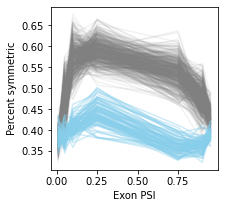

In [14]:
from tqdm import tqdm
fig, ax = plt.subplots(figsize=(3, 3))

# shr = psi.index.intersection


for s in tqdm(psi.columns):
    bins = [1e-2, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[i-1]
        
        vals.append(((df.loc[psi.loc[(psi[s] <= b1) & (psi[s] > b0)].index].LE_n%3)==0).mean())
        
    if vals[0]>0.9:
        continue
    ax.plot(np.array(bins[:-1]), vals, c='gray', alpha=0.1)
#     ax.plot(np.log10(np.array(bins[:-1])), vals, c='gray', alpha=0.1)
        
for s in tqdm(psi_chRNA.columns):
    bins = [1e-2, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99]
    vals = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[i-1]
        vals.append(((df.loc[psi_chRNA.loc[(psi_chRNA[s] <= b1) & (psi_chRNA[s] > b0)].index].LE_n%3)==0).mean())
        
#     if vals[0]>0.9:
#         continue
    ax.plot(np.array(bins[:-1]), vals, c='skyblue', alpha=0.4)
#     ax.plot(np.log10(np.array(bins[:-1])), vals, c='skyblue', alpha=0.4)
        
# ax.set_xticks(np.array(bins[:-1]), ['0.01-0.05', '0.05-0.1', '0.1-0.25', '0.25-0.75'], rotation=45)

ax.set_xlabel('Exon PSI')
ax.set_ylabel('Percent symmetric')

Text(0.5, 1.0, 'NMD event PSI')

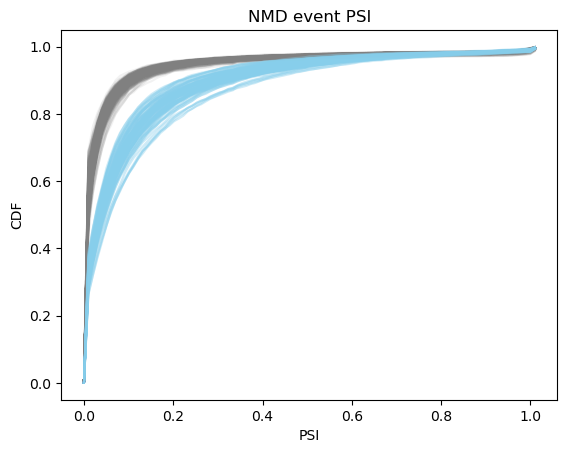

In [55]:
for c in polyA_NMD_psi.columns:
    if c == 'HG00379':
        continue
    plt.plot(np.linspace(0, 1.01, 101), [(polyA_NMD_psi[c]<x).mean() for x in np.linspace(0, 1.01, 101)], c='grey', alpha=0.1)
    
for c in chRNA_NMD_psi.columns:
    plt.plot(np.linspace(0, 1.01, 101), [(chRNA_NMD_psi[c]<x).mean() for x in np.linspace(0, 1.01, 101)], 
             c='skyblue', alpha=0.4)
    
plt.xlabel('PSI')
plt.ylabel('CDF')

plt.title('NMD event PSI')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:01<00:00, 50.60it/s]


Text(0, 0.5, 'Percent symmetric')

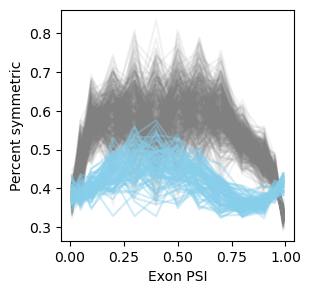

In [101]:
from tqdm import tqdm
fig, ax = plt.subplots(figsize=(3, 3))

# shr = psi.index.intersection

vals_list = []
sample_list = []
assay_list = []
psi_list = []

for s in tqdm(psi.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]
    vals = []
    psi_list_ = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[i-1]
        vals.append(((df.loc[psi.loc[(psi[s] <= b1) & (psi[s] > b0)].index].LE_n%3)==0).mean())
        psi_list_.append(str(b0) + '-' + str(b1))
        
    if vals[0]>0.9:
        continue
    vals_list.extend(vals)
    sample_list.extend([s]*len(vals))
    assay_list.extend(['polyA']*len(vals))
    psi_list.extend(psi_list_)
    
    
    ax.plot(np.array(bins[:-1]), vals, c='gray', alpha=0.1)
#     ax.plot(np.log10(np.array(bins[:-1])), vals, c='gray', alpha=0.1)
        
for s in tqdm(psi_chRNA.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]
    vals = []
    psi_list_ = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[i-1]
        vals.append(((df.loc[psi_chRNA.loc[(psi_chRNA[s] <= b1) & (psi_chRNA[s] > b0)].index].LE_n%3)==0).mean())
        
        psi_list_.append(str(b0) + '-' + str(b1))
        
#     if vals[0]>0.9:
#         continue
    ax.plot(np.array(bins[:-1]), vals, c='skyblue', alpha=0.4)
    vals_list.extend(vals)
    sample_list.extend([s]*len(vals))
    assay_list.extend(['chRNA']*len(vals))
    psi_list.extend(psi_list_)
#     ax.plot(np.log10(np.array(bins[:-1])), vals, c='skyblue', alpha=0.4)
        
# ax.set_xticks(np.log10(np.array(bins[:-1])), ['0.01', '0.05', '0.1', '0.2', '0.3', '0.4', '0.5'])

ax.set_xlabel('Exon PSI')
ax.set_ylabel('Percent symmetric')

In [62]:
df_box = pd.DataFrame()
df_box['assay'] = assay_list
df_box['samples'] = sample_list
df_box['PSI'] = psi_list
df_box['Pct. symmetric'] = vals_list

<Axes: xlabel='PSI', ylabel='Pct. symmetric'>

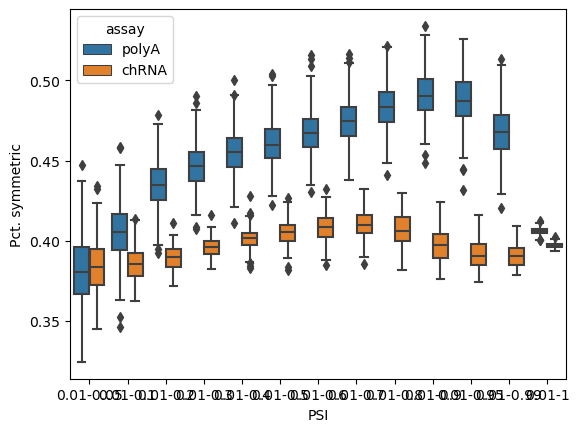

In [65]:
sns.boxplot(data = df_box, x = 'PSI', y='Pct. symmetric', hue='assay')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:01<00:00, 61.18it/s]


Text(0, 0.5, 'Percent alt. protein')

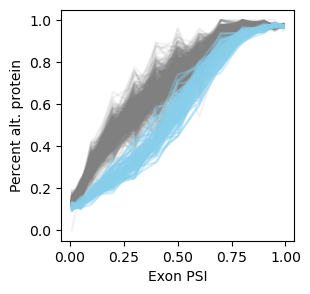

In [110]:
from tqdm import tqdm
fig, ax = plt.subplots(figsize=(3, 3))

# shr = polyA_NMD_event_psi.index.intersection

vals_list = []
sample_list = []
assay_list = []
psi_list = []

for s in tqdm(polyA_NMD_event_psi.columns):
    if c == 'HG00379':
        continue
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]
    vals = []
    psi_list_ = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[i-1]
        
        psi_slice = polyA_NMD_event_psi.loc[(polyA_NMD_event_psi[s] <= b1) & (polyA_NMD_event_psi[s] > b0)].index
        val = (impact.loc[psi_slice].impact == 'alt. protein coding').mean()
        vals.append(val)
        
#         vals.append(((df.loc[polyA_NMD_event_psi.loc[(polyA_NMD_event_psi[s] <= b1) & (polyA_NMD_event_psi[s] > b0)].index].LE_n%3)==0).mean())
        psi_list_.append(str(b0) + '-' + str(b1))
        
    if vals[0]>0.9:
        continue
    vals_list.extend(vals)
    sample_list.extend([s]*len(vals))
    assay_list.extend(['polyA']*len(vals))
    psi_list.extend(psi_list_)
    
    
    ax.plot(np.array(bins[:-1]), vals, c='gray', alpha=0.1)
#     ax.plot(np.log10(np.array(bins[:-1])), vals, c='gray', alpha=0.1)
        
for s in tqdm(chRNA_NMD_event_psi.columns):
    bins = [1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]
    vals = []
    psi_list_ = []
    for i in range(1, len(bins)):
        b1 = bins[i]
        b0 = bins[i-1]
        
        psi_slice = chRNA_NMD_event_psi.loc[(chRNA_NMD_event_psi[s] <= b1) & (chRNA_NMD_event_psi[s] > b0)].index
        val = (impact.loc[psi_slice].impact == 'alt. protein coding').mean()
        vals.append(val)
#         vals.append(((df.loc[chRNA_NMD_event_polyA_NMD_event_psi.loc[(chRNA_NMD_event_polyA_NMD_event_psi[s] <= b1) & (chRNA_NMD_event_polyA_NMD_event_psi[s] > b0)].index].LE_n%3)==0).mean())
        
        psi_list_.append(str(b0) + '-' + str(b1))
        
#     if vals[0]>0.9:
#         continue
    ax.plot(np.array(bins[:-1]), vals, c='skyblue', alpha=0.4)
    vals_list.extend(vals)
    sample_list.extend([s]*len(vals))
    assay_list.extend(['chRNA']*len(vals))
    psi_list.extend(psi_list_)
#     ax.plot(np.log10(np.array(bins[:-1])), vals, c='skyblue', alpha=0.4)
        
# ax.set_xticks(np.log10(np.array(bins[:-1])), ['0.01', '0.05', '0.1', '0.2', '0.3', '0.4', '0.5'])

ax.set_xlabel('Exon PSI')
ax.set_ylabel('Percent alt. protein')

In [75]:
psi_slice = polyA_NMD_event_psi.loc[(polyA_NMD_event_psi[s] <= b1) & (polyA_NMD_event_psi[s] > b0)].index
val = (impact.loc[psi_slice].impact == 'alt. protein coding').mean()

In [79]:
(impact.loc[psi_slice].impact == 'poison exon').mean()

0.12762237762237763

In [88]:
np.mean(impact.loc[polyA_NMD_event_psi.loc[(polyA_NMD_event_psi[s] <= 1) & (polyA_NMD_event_psi[s] > 0.99)].index] == 'poison exon')

EventID    0.000000
ONTO       0.000000
impact     0.018644
dtype: float64

<Axes: xlabel='impact', ylabel='count'>

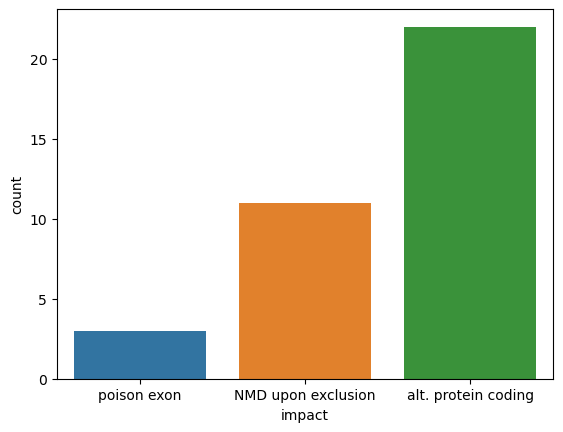

In [109]:
sns.countplot(data = impact.loc[polyA_NMD_event_psi.loc[(polyA_NMD_event_psi[s] <= 0.5) & (polyA_NMD_event_psi[s] > 0.4)].index],
              x = 'impact')

In [94]:
psi_slice = polyA_NMD_event_psi.loc[(polyA_NMD_event_psi[s] <= b1) & (polyA_NMD_event_psi[s] > b0)].index
val = (impact.loc[psi_slice].impact == 'alt. protein coding').mean()

In [97]:
b0

0.01